# Get started 

In this tutorial, we will run TraSig on the example data (and trajectory). We will then analyze TraSig's inference results, including calculating the summary interaction score for cell cluster (type) pairs and conducting GO enrichment analysis on the significant ligands and receptors. 

Alternatively, you may run the script analyze_outputs.py to analyze the outputs from TraSig, after you finish running TraSig using the command-line tool. By running this script, you can obtain all analysis outputs, except for the GO enrichment analysis results. Please refer to [Obtain the analysis results using the command-line tool](#2.1) and **Command-line tools** session in README.md for more details.


**Table of Content**
1. [Run TraSig on the example data](#1)  
2. [Analyze TraSig results](#2) 
    1. [(optional) Obtain the analysis results using the command-line tool](#2.1) 
    2. [Load inputs](#2.2) 
    3. [Load outputs](#2.3)  
    4. [Adjust p-values for multiple comparisons](#2.4) 
    5. [Infer interactions among cell clusters (edges)](#2.5) 
    6. [Go analysis](#2.6)  

**Extra Package Requirements**   
(all packages below should already be installed when installing TraSig)
* statsmodels >= 0.12.1 (required for post-analysis only)
* scipy >= 1.5.4 (required for post-analysis only)
* matplotlib >= 3.3.4 (required for post-analysis only)
* seaborn >= 0.11.0 (required for post-analysis only)

In [1]:
import pickle
import sys
import os
import gc

import numpy as np
import bottleneck as bn
import pandas as pd

# load packages required for analysis 
import statsmodels.api as sm
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. Run TraSig on the example data
<a id=1></a>

1. The inputs are prepared following the Prepare_input_from_dynverse_ti_methods.ipynb tutorial.
2. For the following demo, we run 1e5 permutations using multiprocessing with 8 cores. 

In [2]:
%time ! main.py -i ../example/input -o ../example/output -d oligodendrocyte-differentiation-clusters_marques -g None -b ti_slingshot -c 8 -n 100000 -s smallerWindow

Namespace(input='../example/input', listType='ligand_receptor', metric='dot', modelName='ti_slingshot', multiProcess=True, nLap=20, nan2zero=True, ncores='8', numPerms='100000', output='../example/output', preprocess='None', project='oligodendrocyte-differentiation-clusters_marques', startingTreatment='smallerWindow')
Load:  oligodendrocyte-differentiation-clusters_marques_lr.txt
Permutations grouped to different cores: [range(1, 14286), range(14286, 28571), range(28571, 42856), range(42856, 57141), range(57141, 71426), range(71426, 85711), range(85711, 99996), range(99996, 100001)]
CPU times: user 35 s, sys: 4.64 s, total: 39.6 s
Wall time: 44min 5s


# 2. Analyze TraSig results
<a id=2></a>

## 2.1 (Optional) Obtain the analysis results using the command-line tool
<a id=2.1></a>
* You can run the following script to obtain all analysis outputs, except for the GO analysis results.
* Alternatively, you may follow the break-downs starting from [Load inputs](#2.2) to obtain the analysis outputs.

In [4]:
%time ! python analyze_outputs.py -i ../example/input -o ../example/output -d oligodendrocyte-differentiation-clusters_marques -g None -b ti_slingshot -e None -n 100000 -s smallerWindow

Namespace(input='../example/input', listType='ligand_receptor', metric='dot', modelName='ti_slingshot', nLap=20, nan2zero=True, numPerms='100000', otherIdentifier='None', output='../example/output', preprocess='None', project='oligodendrocyte-differentiation-clusters_marques', startingTreatment='smallerWindow')
Load:  oligodendrocyte-differentiation-clusters_marques_lr.txt
Analysis outputs to be saved to ../example/output/analysis
CPU times: user 38.7 ms, sys: 10.5 ms, total: 49.2 ms
Wall time: 1.98 s


## 2.2 Load inputs
<a id=2.2></a>

* May need to modify the following variables based on your inputs and arguments for TraSig

In [2]:
project = "oligodendrocyte-differentiation-clusters_marques"
preprocess = ""
model_name = "ti_slingshot"
others = ""
list_type = 'ligand_receptor'
startingTreatment = "smallerWindow"

n_lap = 20 # smoothing window size 
metrics = ['dot']
nan2zero = True
num_perms = 1e5

# set the path to TraSig's inputs 
input_path = '../example/input'
# set the path to TraSig's outputs; 
# the analysis outpus will be saved at output_path/analysis
output_path = '../example/output'  

##### Load TraSig's inputs.

In [3]:
if preprocess != "":
    _preprocess = f"_{preprocess}"
else:
    _preprocess = ""
    
if startingTreatment != "None":
    _startingTreatment = f"_{startingTreatment}"
else:
    _startingTreatment = ""

suffix = f"{project}_{list_type}{_preprocess}_{model_name}"
suffix = f"{suffix}{_startingTreatment}_nlap_{n_lap}{others}"
child_suffix = f"{suffix}_{metrics[0]}_{int(np.log10(num_perms))}"

# get interaction file (list of (ligand, receptor/target))
filename = f"{list_type}_{project}{_preprocess}.pickle"
with open(os.path.join(input_path, filename), 'rb') as handle:
    interaction_list = pickle.load(handle)

  
# load expression data
filename = f"{project}{_preprocess}_lr.txt"
print("Load: ", filename)

data_file = os.path.join(input_path, filename)
df = pd.read_csv(data_file, index_col=0)
cell_exps = df.values
gene_names = list(df.columns.values)  # assume unique


# (optional) load corresponding between sampling time and path
filename = f"sampling_time_per_path_{project}{_preprocess}_{model_name}.pickle"
with open(os.path.join(input_path, filename), 'rb') as handle:
    time2path = pickle.load(handle)

path2time = dict()
for k, ps in time2path.items():
    for p in ps:
        path2time[p] = k

        
# load path & time assignment
# original assignment
hid_var_file = f"{project}{_preprocess}_{model_name}_it2_hid_var.pickle"
with open(os.path.join(input_path, hid_var_file), 'rb') as handle:
    hid_var = pickle.load(handle, encoding="latin1")

unique_paths = np.unique(hid_var["cell_path"])
all_times = [round(i, 2) for i in np.arange(0, 1.01, 0.01)]  # all possible labels for cell time
cell_paths_o = hid_var["cell_path"]
cell_times_o = hid_var["cell_time"]


Load:  oligodendrocyte-differentiation-clusters_marques_lr.txt


## 2.3 Load outputs
<a id=2.3></a>

In [4]:
# load the scores on the observed original data 
_n = 0

_columns = dict.fromkeys(metrics)
for m in metrics:
    _columns[m] = []

_columns.update({'pair': [], 'gene_pair_id': []})

# load results  
filename = f"{suffix}_metrics_{_n}.pickle"
data_file = os.path.join(output_path, filename)

with open(data_file, 'rb') as handle:
    results = pickle.load(handle)

for pair, mets in results.items():
    for m in metrics:
        _columns[m] += list(mets[m])

    _columns['pair'] += list(np.repeat(pair, len(mets[m])))
    _columns['gene_pair_id'] += list(range(len(mets[m])))
    
df = pd.DataFrame(_columns)
num_pairs = len(results[pair][m])


# load permutation results  
filename = f"{suffix}_permutation_results.pickle"
data_file = os.path.join(output_path, filename)

with open(data_file, 'rb') as handle:
    pair2counts = pickle.load(handle)

    
# turn to p-values
for pair, _ in pair2counts.items():
    for m in metrics:
         pair2counts[pair][m] = (pair2counts[pair][m] + 1)/(num_perms + 1)

            
# add to the dataframe            
_columns = dict.fromkeys(metrics)
for m in metrics:
    _columns[m] = []

for pair, counts in pair2counts.items():
    for m in metrics:
        _columns[m] += list(counts[m])
        
for m in metrics:
    df[f"{m}_p"] = _columns[m]

In [5]:
# add ligand target info
df['ligand'] = [interaction_list[int(i)][0] for i in df['gene_pair_id']]
df['target'] = [interaction_list[int(i)][1] for i in df['gene_pair_id']]
ligand_list = np.unique(df['ligand'])

# add more info about cell clusters 
df['sender'] = [i.split('_')[0] for i in df['pair']]
df['receiver'] = [i.split('_')[1] for i in df['pair']]
df['sender'] = df['sender'].astype('int')
df['receiver'] = df['receiver'].astype('int')
df['time-sender'] = [path2time[i] for i in df['sender']]
df['time-receiver'] = [path2time[i] for i in df['receiver']]

#### label clusters using the true labels of the majority of cells (for plotting)

In [6]:
# build path2 label

unique_days = np.unique(hid_var['cell_labels'])
cell_paths = np.unique(hid_var["cell_path"])

_dict = dict.fromkeys(range(len(cell_paths)))  

for i, cur_path in enumerate(cell_paths):
    print("------current path", cur_path)
    
    # get data corresponding to a path
    condition = hid_var["cell_path"] == cur_path
    cur_labels = hid_var['cell_labels'][condition]
    try:
        cur_labels = [i.decode('UTF-8') for i in cur_labels]
    except AttributeError:
        pass 
    
    # get the sampling time for the majority cells 
    mode, count = stats.mode(cur_labels)
    
    major_percent = round(float(count[0])/len(cur_labels), 2)
    print(mode[0], major_percent)
    
    cur_label = mode[0]
    
    # add more labels if cells of the major cell type make less than 90% of the whole population 
    if  major_percent < 0.9:
        cur_label += '(' + str(major_percent) + ')'
        
        labels, counts = np.unique(cur_labels, return_counts=True)
        sorted_counts, idxs = np.unique(counts, return_index=True)
       #  print(zip(sorted_counts, labels[idxs]))
        
        count = 0
        while major_percent < 0.9:
            # add more labels until major_percent >= 0.9
            add_counts = sorted_counts[::-1][1+count]
            _add_percent = round(add_counts/len(cur_labels), 2)
    
            major_percent += _add_percent
            print(major_percent)
            
            cur_label += '\n '
            cur_label += labels[idxs][::-1][1+count]
            cur_label += '(' + str(round(_add_percent, 2)) + ')'
            
            count += 1
    
    _dict[cur_path] = cur_label
    
path2label = _dict

------current path 0
MOL 0.72
0.97
------current path 1
NFOL 0.75
0.92
------current path 2
MOL 1.0
------current path 3
MOL 1.0


## 2.4 Adjust p-values for multiple comparisons
<a id=2.4></a>

Here we use the BH procedure to control the FDR rate.

In [7]:
_p = df['dot_p'].values.copy()

for pair in results.keys(): 
    condition = np.where(df['pair'] == pair)[0]
    adjusted = sm.stats.multitest.fdrcorrection(df['dot_p'].values[condition])
    _p[condition] = adjusted[1]

In [8]:
df['dot_p_adjusted'] = _p

In [9]:
columns = ['pair','sender', 'receiver', 'time-sender', 'time-receiver', 'gene_pair_id', 
           'ligand', 'target', 'dot', 'dot_p', 'dot_p_adjusted']

df[columns].head()

,pair,sender,receiver,time-sender,time-receiver,gene_pair_id,ligand,target,dot,dot_p,dot_p_adjusted
0,0_0,0,0,0,0,0,ADAM17,NOTCH1,0.242648,0.000680,0.001587
1,0_0,0,0,0,0,1,AGRN,ATP1A3,0.668552,0.000120,0.000931
2,0_0,0,0,0,0,2,AGRP,SDC3,0.008098,0.005690,0.012122
3,0_0,0,0,0,0,3,APOE,LRP1,1.583651,0.000050,0.000931
4,0_0,0,0,0,0,4,APOE,SORL1,0.200087,0.171918,0.210600


## 2.5 Infer interactions among cell clusters (edges)
<a id=2.5></a>

For each cluster pair, using the results for ligand-receptors, we infer the overall interacting score by counting how many of the ligand-receptors are significant. 

In [10]:
# reset output path to save analysis results
output_path = f"{output_path}/analysis"

if not os.path.exists(output_path):
    os.makedirs(output_path)

### Calculate summary score over all ligand-receptor pairs 

In [11]:
df_pool = pd.DataFrame(list(set(df['pair'])))
df_pool.columns = ['pair']

df_pool['sender'] = [i.split('_')[0] for i in df_pool['pair']]
df_pool['receiver'] = [i.split('_')[1] for i in df_pool['pair']]
df_pool['sender'] = df_pool['sender'].astype('int')
df_pool['receiver'] = df_pool['receiver'].astype('int')
df_pool['time-sender'] = [path2time[i] for i in df_pool['sender']]
df_pool['time-receiver'] = [path2time[i] for i in df_pool['receiver']]
# df_pool = df_pool[df_pool['time-sender'] == df_pool['time-receiver']]  # if only keep pairs sampled at the same time

In [12]:
cutoff =  0.05
name_p = 'dot_p_adjusted'

_counts = []
for p in df_pool['pair']:
    condition = df['pair'] == p
    _counts.append((df[condition][name_p] < cutoff).sum())
    
df_pool['counts'] = _counts

# subset only contains significant pairs
condition = df[name_p] < cutoff
df_sig = df[condition].copy()
df_sig.reset_index(inplace=True)

In [13]:
# order clusters (edges / paths) by sampling time 
path_order_time = []
for k,v in time2path.items():
    path_order_time = path_order_time + v

df_pool['sender'] =  pd.Categorical(df_pool['sender'], path_order_time)
df_pool['receiver'] =  pd.Categorical(df_pool['receiver'], path_order_time)
df_pool.sort_values(['sender','receiver'],inplace=True)

In [14]:
_vmin = min(df_pool['counts'])
_vmax = max(df_pool['counts'])

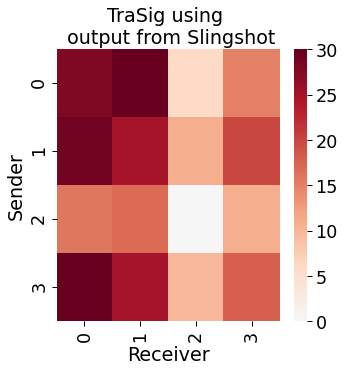

In [15]:
method = "TraSig"
metric = 'counts'

_center_value = _vmin
# plot only pairs sampled at the same time 
df_plot = df_pool[df_pool['time-sender'] == df_pool['time-receiver']].pivot(index='sender', columns='receiver', values=metric)

# sort by column names
df_plot = df_plot.sort_index(axis=1)

# sns.set_style("white")
plt.figure(figsize=(5, 5))
sns.set_context("paper", font_scale=2) 

ax = sns.heatmap(df_plot.values, xticklabels=True, yticklabels=True, 
                 vmin = _vmin, vmax = _vmax, center = _center_value, cmap = "RdBu_r")
plt.xticks(rotation=90)
plt.ylabel("Sender")
plt.xlabel('Receiver')
ax.set_xticklabels(df_plot.index.values)
ax.set_yticklabels(df_plot.index.values)

if 'tf' in model_name:
    _traj = 'CSHMM'
    plt.title(f"{method} using \n output from {_traj}")
else:
    _traj = model_name.split('_')[1].capitalize()
    plt.title(f"{method} using \n output from {_traj}")

filename = f"{child_suffix}_summary_scores.png"
plt.savefig(os.path.join(output_path, filename), bbox_inches = "tight", dpi=300, format = "png")
filename = f"{child_suffix}_summary_scores.eps"
plt.savefig(os.path.join(output_path, filename), bbox_inches = "tight", dpi=300, format = "eps")

##### save summary score 

In [16]:
df_pool['sender-label'] = df_pool['sender'].replace(path2label)
df_pool['receiver-label'] = df_pool['receiver'].replace(path2label)

cols_order = ['sender','sender-label','receiver','receiver-label', 'counts']
df_out = df_pool[cols_order].copy()

filename = f"{child_suffix}_summary_score.csv"
df_out.to_csv(os.path.join(output_path, filename), index=False)

### save significant ligand-receptor pairs

In [17]:
df_sig['sender-label'] = df_sig['sender'].replace(path2label)
df_sig['receiver-label'] = df_sig['receiver'].replace(path2label)

# sort ligand-receptors in each cluster pair by their scores 
_dfs =[] 
pairs_ts = np.unique(df_sig['pair'])
for pair in pairs_ts:
    condition = df_sig['pair'] == pair
    _dfs.append(df_sig[condition].sort_values('dot', ascending=False))
    
df_sorted = pd.concat(_dfs)
cols_order = ['pair', 'time-sender','sender','sender-label','time-receiver', 'receiver','receiver-label', 'ligand', 'target', \
              'dot', 'dot_p', 'dot_p_adjusted']
df_sorted = df_sorted[cols_order]


df_sorted.columns = ['interaction pair' ,'sender sampling time', 'sender','sender-label','receiver sampling time','receiver','receiver-label', 'ligand', 'target', 
                   'score', 'score p-value', 'score p-value adjusted']

filename = f"{child_suffix}_significant_pairs.csv"
df_sorted.to_csv(os.path.join(output_path, filename), index=False)

## 2.6 GO enrichment analysis
<a id=2.6></a>

For selected cluster pairs, we use the significant ligands and receptors to conduct GO enrichment analysis. Here we use the analysis on all interactions acting on either cluster 0 or 1 as an example. 

In [18]:
# select interacting pairs for GO analysis
pairs_dict = {"0": ["0_0", "1_0", "2_0", "3_0"], "1": ["0_1", "1_1", "2_1", "3_1"]}

# create the varaible with both ligand and receptor name 
df_sig['lr'] = [f"{df_sig['ligand'][i]}_{df_sig['target'][i]}"for i in range(df_sig.shape[0])]

### Get enriched GO terms using gProfiler

In [19]:
import requests

def getGO(input_genes, out_file_name=None, save2file=False):
    """
    Modified based on output analysis in CSHMM.
    
    Author: Chieh Lin
    Link to original code: https://github.com/jessica1338/CSHMM-for-time-series-scRNA-Seq/blob/master/CSHMM_analysis.py
    
    """

    r = requests.post(
            url = 'https://biit.cs.ut.ee/gprofiler/api/gost/profile/',
            json = {
                'organism':species,
                'query':list(input_genes),
                }
        )


    if "result" not in r.json():
        return 

    res = r.json()['result']
    if len(res) > 0:
        columns = res[0].keys()
        out_df = pd.DataFrame()
        for col in columns:
            if col == "intersections":
                continue
            tmp = [r[col] for r in res]
            out_df[col] = tmp
            
        if save2file and out_file_name is not None: 
            out_df.to_csv(out_file_name, sep="\t", index=False, encoding="utf-8")
            
        return out_df

In [20]:
# a helper function
flatten = lambda t: [item for sublist in t for item in sublist]

In [22]:
species = "mmusculus"
# species = "hsapiens"
read_saved = False

go_results = dict.fromkeys(pairs_dict.keys())

for cur_cell_type in ["0", "1"]:
    all_pairs = pairs_dict[cur_cell_type]
    
    all_out_dfs = []
    for i in range(len(all_pairs)):
        pair = all_pairs[i]

        filename = f"GO_{pair}_{child_suffix}.csv"
        directory = f"{output_path}/GO_analysis"
        if not os.path.exists(directory):
            os.makedirs(directory)

        out_file_name = f"{directory}/{filename}"

        if read_saved:
            out_df = pd.read_csv(out_file_name, sep='\t')
        else:
            _lrs_tg = set(df_sig[df_sig['pair'] == pair]['lr'].values)
            _lrs_flat_tg = set(flatten([i.split("_") for i in _lrs_tg]))
            input_genes = list(_lrs_flat_tg)

            print(f"Number of genes used for searching for {pair}: {len(input_genes)}")

            out_df = getGO(input_genes, out_file_name=out_file_name, save2file=True)

        if out_df is not None:
            all_out_dfs.append(out_df)
            
    go_results[cur_cell_type] = all_out_dfs

Number of genes used for searching for 0_0: 37
Number of genes used for searching for 1_0: 41
Number of genes used for searching for 2_0: 24
Number of genes used for searching for 3_0: 41
Number of genes used for searching for 0_1: 39
Number of genes used for searching for 1_1: 36
Number of genes used for searching for 2_1: 27
Number of genes used for searching for 3_1: 36


### analysis on enrichment results

In [23]:
def findGOterms(keywords,goprofile_results,all_pairs):
    _terms = []
    used_keywords = []
    
    for k in range(len(all_pairs)):
        try:
            for i in goprofile_results[k]['name']:
                for j in keywords:
                    if j in i.split(' '):
                        _terms.append(i)
                        used_keywords.append(j)
        except IndexError:
            continue
            
    _terms = list(np.unique(_terms))
    
    return _terms, used_keywords

In [24]:
all_dev_terms = []

for cur_go_results_name, cur_go_results  in go_results.items():
    
    # find development related terms
    keywords = ['Development','development','regeneration','morphogenesis', 'formation', "differentiation",
               "migration", 'localization', 'locomotion', 'motility', 'movement', 'developmental', 'multicellular']
    results, used_dev = findGOterms(keywords, cur_go_results, all_pairs)
    all_dev_terms += results 


In [25]:
terms_sets = {'development':np.unique(all_dev_terms)}

#### plot GO analysis results for selected terms

In [26]:
cur_go_names = 'development'
cur_go_terms = terms_sets[cur_go_names]

In [27]:
_max = 0
_min = 1e2

In [28]:
df_plots = dict.fromkeys(go_results.keys())

In [29]:
for cur_go_results_name, cur_go_results  in go_results.items():
    _ps = []
    _terms = []
    _pairs = []
    
    all_pairs = pairs_dict[cur_go_results_name]
    
    for _term in cur_go_terms:
        for i in range(len(all_pairs)):
            pair = all_pairs[i]
            cur_df = cur_go_results[i]

            if _term in cur_df['name'].values:
                _p = cur_df['p_value'][cur_df['name'] == _term].values[0]
            else: 
                _p = np.nan

            _ps.append(_p)
            _terms.append(_term)
            _pairs.append(pair)
            
    df_summary = pd.DataFrame([_pairs,_terms,_ps]).T
    
    df_summary.columns = ['interacting pair', 'GO term', 'p-value']
    df_summary['log10p'] = - np.log10(df_summary['p-value'].astype('float').values)
    
    df_summary.sort_values('GO term', inplace=True)
    df_plot = df_summary.pivot(index='GO term', columns='interacting pair', values='log10p')
    
    if df_summary['log10p'].max() > _max:
        _max = df_summary['log10p'].max()
    
    if df_summary['log10p'].min() < _min:
        _min = df_summary['log10p'].min()
    
    df_plots[cur_go_results_name] = df_plot[all_pairs]
   

##### filter to display only highly significant ones
1. keep terms with minimum p-value among all interacting pairs below some cutoff

In [30]:
def convert2p(vals):
    """
    Convert -log10(p) back to p.
    """
    return np.power(10, -vals)

In [31]:
results = []

for k, v in df_plots.items():
    results.append(v)

In [32]:
temp = pd.concat(results, axis=1)
temp['GO'] = temp.index
_max_all_methods = temp.max(axis=1)

In [33]:
cutoff = np.quantile(_max_all_methods, 0.9)
print(f"Cutoff p-value: {convert2p(cutoff)}")

Cutoff p-value: 2.152599861968056e-12


In [34]:
# filter GO terms 
cur_go_terms = temp['GO'][_max_all_methods > cutoff].values

In [35]:
df_plots = dict.fromkeys(go_results.keys())

In [36]:
_max = 0
_min = 1e2

In [37]:
for cur_go_results_name, cur_go_results  in go_results.items():
    _ps = []
    _terms = []
    _pairs = []
    
    all_pairs = pairs_dict[cur_go_results_name]
    
    for _term in cur_go_terms:
        for i in range(len(all_pairs)):
            pair = all_pairs[i]
            cur_df = cur_go_results[i]

            if _term in cur_df['name'].values:
                _p = cur_df['p_value'][cur_df['name'] == _term].values[0]
            else: 
                _p = np.nan

            _ps.append(_p)
            _terms.append(_term)
            _pairs.append(pair)
            
    df_summary = pd.DataFrame([_pairs,_terms,_ps]).T
    
    df_summary.columns = ['interacting pair', 'GO term', 'p-value']
    df_summary['log10p'] = - np.log10(df_summary['p-value'].astype('float').values)
    
    df_summary.sort_values('GO term', inplace=True)
    df_plot = df_summary.pivot(index='GO term', columns='interacting pair', values='log10p')
    
    if df_summary['log10p'].max() > _max:
        _max = df_summary['log10p'].max()
    
    if df_summary['log10p'].min() < _min:
        _min = df_summary['log10p'].min()
    
    df_plots[cur_go_results_name] = df_plot[all_pairs]
   

In [38]:
df_plots_names = list(df_plots.keys())

In [39]:
_vmin = _min
_vmax = _max

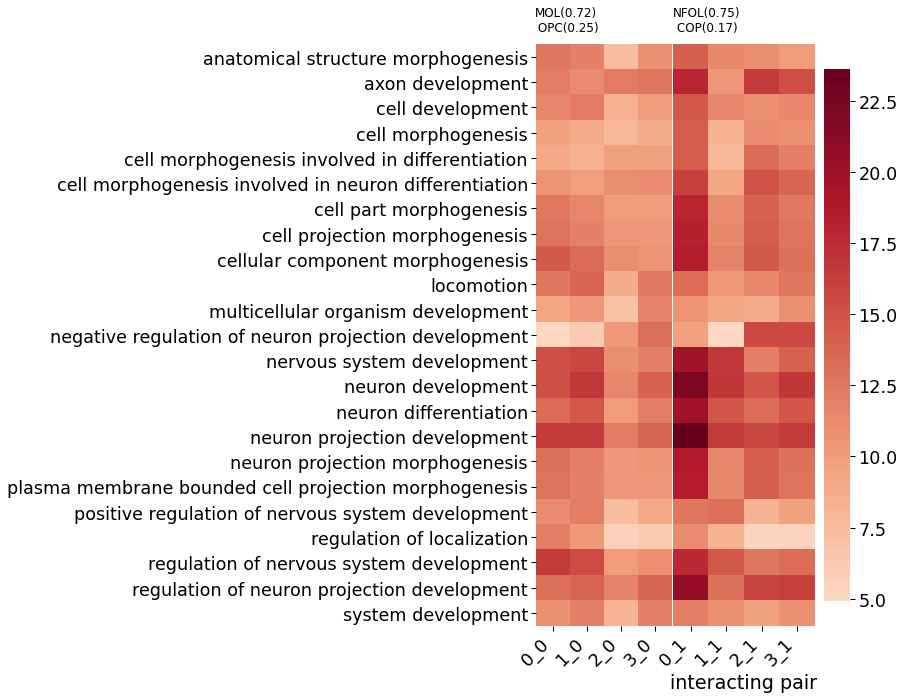

In [40]:
portrait = False
cmaps = ["RdBu_r",'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']
palettes = cmaps[0]

sns.set_context("paper", font_scale=2) 

SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

rotation_r = 0
rotation_c = 45

if portrait:
    fig, axes = plt.subplots(2,1,figsize=(10,17), gridspec_kw={'height_ratios': [1,1]})  # portrait 
else:
    fig, axes = plt.subplots(1,2,figsize=(12, 9), gridspec_kw={'width_ratios': [1,1.3]})


for i in range(len(df_plots_names)):
    ax = axes[i]
    
    _name = df_plots_names[i]
    
    if portrait:
        df_plot = df_plots[_name].T
    else:
        df_plot = df_plots[_name]
    
    if portrait == True:
        cbar = True
    else:
        if i == len(df_plots_names) - 1:
            cbar = True
        else:
            cbar = False

    sns.heatmap(df_plot, xticklabels=True, yticklabels=True,
                         ax = ax, vmax=_vmax, vmin=_vmin, cbar=cbar,center=0,cmap=palettes)
    
    if portrait:
        ax.set_xlabel('')
        if i != 2:
            ax.xaxis.set_major_locator(plt.NullLocator())
        else:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation_c, horizontalalignment='right')
            
        ax.set_yticklabels(ax.get_yticklabels(), rotation=rotation_r, horizontalalignment='right')

    else:
        ax.set_ylabel('')
        if i != 0:
            ax.yaxis.set_major_locator(plt.NullLocator())
        else:
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
            
        ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation_c, horizontalalignment='right')
        
    if i != 1:
        ax.set_xlabel('') 

fig.tight_layout(pad=0.01)
 
for i in range(len(df_plots_names)):
    _name= path2label[int(df_plots_names[i])]
    ax_main = axes[i]
    
    bbox = ax_main.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    if portrait:
        text = ax_main.text(width+27.7, 3, _name, size=SMALL_SIZE, horizontalalignment = 'left',
                       verticalalignment='top', rotation=270)   
    else:
        text = ax_main.text(width/2 - 1,  -1.5, _name, size=SMALL_SIZE, horizontalalignment = 'left',
                       verticalalignment='top', rotation=0)
    

filename = f"GO_summary_log10p_{child_suffix}_{cur_go_names}.png"
plt.savefig(os.path.join(output_path, filename),dpi=300, bbox_inches = "tight", format='png')

filename = f"GO_summary_log10p_{child_suffix}_{cur_go_names}.eps"
plt.savefig(os.path.join(output_path, filename), bbox_inches = "tight", dpi=300,  format='eps')
plt.show()
plt.close()